In [1]:
!pip install -q -U kaggle_environments

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Loading environment lux_ai_s3 failed: No module named 'gymnax'


In [7]:
# Определение агентов с различными стратегиями

# Агент 1: Всегда выбирает "камень"
def rock_agent(observation, configuration):
    return 0  # Камень

# Агент 2: Всегда выбирает "бумагу"
def paper_agent(observation, configuration):
    return 1  # Бумага

# Агент 3: Всегда выбирает "ножницы"
def scissors_agent(observation, configuration):
    return 2  # Ножницы

# Агент 4: Случайно выбирает "камень", "бумагу" или "ножницы"
def random_agent(observation, configuration):
    return random.randrange(0, configuration.signs)

# Агент 5: Копирует ход оппонента с предыдущего раунда
def copy_opponent_agent(observation, configuration):
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        return random.randrange(0, configuration.signs)

# Агент 6: Контр-ход на предыдущий ход оппонента
def counter_opponent_agent(observation, configuration):
    if observation.step > 0:
        # Контр-ход на предыдущий ход оппонента
        return (observation.lastOpponentAction + 1) % configuration.signs
    else:
        return random.randrange(0, configuration.signs)

# Агент 7: Статистический агент
# Анализирует историю ходов оппонента и играет против наиболее частого
def statistical_agent(observation, configuration):
    import random
    if not hasattr(statistical_agent, "opponent_history"):
        statistical_agent.opponent_history = []
    if observation.step > 0:
        statistical_agent.opponent_history.append(observation.lastOpponentAction)
        # Находим наиболее частый ход оппонента
        most_common = max(set(statistical_agent.opponent_history), key=statistical_agent.opponent_history.count)
        # Играем контр-ход к наиболее частому
        return (most_common + 1) % configuration.signs
    else:
        # Инициализация истории и случайный начальный ход
        statistical_agent.opponent_history = []
        return random.randrange(0, configuration.signs)

# Агент 8: Циклический агент
def cycle_agent(observation, configuration):
    return observation.step % configuration.signs


In [8]:
# Список агентов и их названий
agents = [
    rock_agent,
    paper_agent,
    scissors_agent,
    random_agent,
    copy_opponent_agent,
    counter_opponent_agent,
    statistical_agent,
    cycle_agent
]

agent_names = [
    "Всегда Камень",
    "Всегда Бумага",
    "Всегда Ножницы",
    "Случайный",
    "Копирует Оппонента",
    "Контр-Оппонент",
    "Статистический",
    "Циклический"
]



In [9]:
def run_tournament(agents, agent_names, num_episodes=100):
    results_df = pd.DataFrame(0, index=agent_names, columns=agent_names)

    # Проведение турнира
    for i, agent1 in enumerate(agents):
        for j, agent2 in enumerate(agents):
            if i != j:
                # Оценка агентов
                outcomes = evaluate(
                    "rps",
                    [agent1, agent2],
                    configuration={"episodeSteps": num_episodes},
                    num_episodes=1
                )
                # Суммарная награда для первого агента
                agent1_total = sum([outcome[0] for outcome in outcomes])
                # Обновление DataFrame результатов
                results_df.iloc[i, j] = agent1_total

    print("Результаты турнира:")
    display(results_df)

    # Визуализация результатов
    plt.figure(figsize=(10, 8))
    sns.heatmap(results_df, annot=True, fmt="d", cmap="RdYlGn")
    plt.title("Результаты турнира 'Камень-Ножницы-Бумага'")
    plt.xlabel("Оппонент")
    plt.ylabel("Агент")
    plt.show()

    # Подсчет общих результатов для каждого агента
    total_scores = results_df.sum(axis=1)

    # DataFrame для ранжирования
    ranking_df = total_scores.sort_values(ascending=False).reset_index()
    ranking_df.columns = ['Агент', 'Общий счет']

    print("Итоговый рейтинг агентов:")
    display(ranking_df)

    return results_df, ranking_df


Результаты турнира:


,Всегда Камень,Всегда Бумага,Всегда Ножницы,Случайный,Копирует Оппонента,Контр-Оппонент,Статистический,Циклический
Всегда Камень,0,-99,99,0,0,-98,-98,0
Всегда Бумага,99,0,-99,0,0,-97,-98,0
Всегда Ножницы,-99,99,0,0,0,-99,-97,0
Случайный,0,0,0,0,0,0,0,0
Копирует Оппонента,0,0,0,0,0,-50,-21,-99
Контр-Оппонент,98,97,97,0,-99,0,49,0
Статистический,99,98,99,0,20,-48,0,0
Циклический,0,0,0,0,99,0,0,0


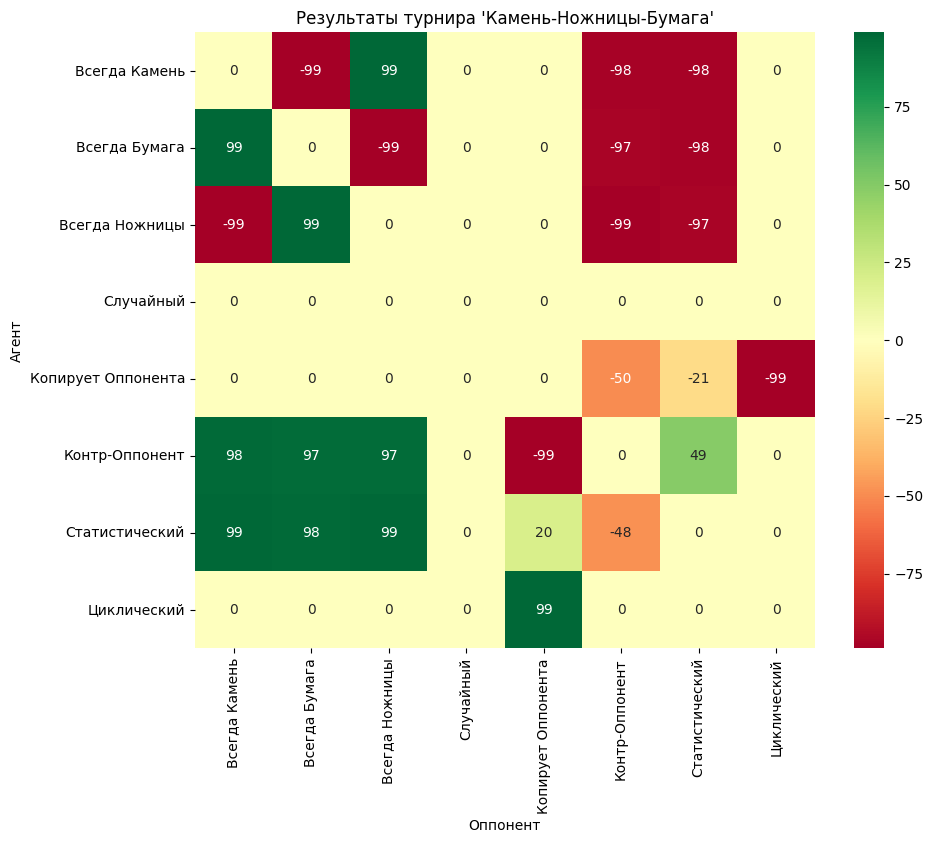

Итоговый рейтинг агентов:


,Агент,Общий счет
0,Статистический,268
1,Контр-Оппонент,242
2,Циклический,99
3,Случайный,0
4,Копирует Оппонента,-170
5,Всегда Бумага,-195
6,Всегда Камень,-196
7,Всегда Ножницы,-196


In [10]:
results_df, ranking_df = run_tournament(agents, agent_names, num_episodes=100)
